In [1]:
! pip install googlesearch-python -q

In [2]:
import sys

sys.path.append("..")
from typing import List

import requests
from bs4 import BeautifulSoup
from googlesearch import search
from pydantic import BaseModel, Field

from brain.sdk import BrainClient

In [3]:
brain_client = BrainClient("http://127.0.0.1:8000")

In [4]:
SEARCH_RESULTS_LIMIT = 5  # Number of search results to fetch
SCRAPE_TIMEOUT = 5        # Timeout for each article scrape request

# %%
# Reasoner 1: Keyword Extractor
class ExtractedKeywords(BaseModel):
    keywords: List[str] = Field(..., description="List of keywords extracted from the tweet.")
0
@brain_client.reasoner(schema=ExtractedKeywords)
def keyword_extractor(tweet: str):
    # Mock keyword extraction by splitting the tweet into words
    keywords = [word for word in tweet.split() if len(word) > 3]
    return (
        f"Extract keywords from tweet: {keywords}",
        "Analyze the tweet and extract relevant keywords for article generation."
    )
keyword_extractor_id = keyword_extractor.register()

In [5]:
# Reasoner 2: Query Generator
class SearchQuery(BaseModel):
    query: List[str] = Field(..., description="The generated search query.")

@brain_client.reasoner(schema=SearchQuery)
def query_generator(keywords: List[str], person: str):
    # Generate a search query based on keywords and person's name
    query = f"{person} {' '.join(keywords)}"
    return (
        f"Generated search query: {query}",
        f"Generate a search query using the keywords {keywords} and the name {person}."
    )
query_generator_id = query_generator.register()

In [6]:
# Reasoner 3: Web Search and Article Content Extraction
class Article(BaseModel):
    title: str = Field(..., description="The title of the article.")
    content: str = Field(..., description="The main text content of the article.")

class SearchResults(BaseModel):
    articles: List[Article] = Field(..., description="List of articles fetched from the web search.")

@brain_client.reasoner(schema=SearchResults)
def web_search_and_scrape(query: List):
    # Perform a Google search
    search_query = " | ".join([f'"{word}"' for word in query])
    search_results = search("("+search_query+")", num_results=SEARCH_RESULTS_LIMIT)
    articles = []

    for url in search_results:
        try:
            # Fetch the article content
            response = requests.get(url, timeout=SCRAPE_TIMEOUT)
            response.raise_for_status()
            soup = BeautifulSoup(response.content, "html.parser")

            # Extract the article's title and main content
            title = soup.title.string.strip() if soup.title else "No Title"
            paragraphs = soup.find_all("p")
            content = " ".join(p.text.strip() for p in paragraphs if p.text)

            # Add to the list of articles
            articles.append(Article(title=title, content=content))  # Truncate content to 1000 chars for brevity

        except Exception as e:
            print(f"Failed to fetch content from {url}: {e}")

    return (
        f"Fetched and scraped articles for query '{query}': {articles}",
        f"Search Google for '{query}' and scrape the content of the top results."
    )
web_search_id = web_search_and_scrape.register()

In [7]:
# Reasoner 4: Article Summarizer
class ArticleSummary(BaseModel):
    title: str = Field(..., description="The title of the article.")
    summary: str = Field(..., description="A short summary of the article content.")

@brain_client.reasoner(schema=ArticleSummary)
def article_summarizer(article: Article):
    # Generate a simple summary by truncating the content
    summary = article.content
    return (
        f"Summarize article '{article.title}'. Summary: {summary}",
        f"Summarize the content of the article '{article.title}'."
    )
article_summarizer_id = article_summarizer.register()


In [8]:
# Reasoner 5: Article Generator
class GeneratedArticle(BaseModel):
    title: str = Field(..., description="The title of the generated article.")
    content: str = Field(..., description="The body of the generated article, referencing the tweet and personality.")

@brain_client.reasoner(schema=GeneratedArticle)
def article_generator(tweet: str, person: str, summaries: List[ArticleSummary]):
    # Craft the article content with a strong focus on the tweet and the personality
    content = f"{person} recently tweeted: '{tweet}'\n\n"
    content += (
        f"This statement has sparked widespread discussion and interest. "
        f"Below are insights from recent articles related to {person}'s views:\n\n"
    )
    content += "\n\n".join(
        [f"**Related Article:** {summary.title}\nSummary: {summary.summary}" for summary in summaries]
    )
    content += (
        f"\n\n{person}'s influence on this topic highlights the importance of these developments. "
        f"Their tweet has opened the door to critical conversations."
    )
    return (
        f"Generated article referencing {person}'s tweet\n{content}...",
        f"""Generate a cohesive article combining {person}'s tweet, recent articles, and their influence.
        Dont directly reference the articles we have found, instead use them to inform the article you are writing. Dont hallucinate, only use the information we have found and you know from your inner knowldge"""
    )
article_generator_id = article_generator.register()

In [9]:
# Reasoner 6: Title Creator
class CatchyTitle(BaseModel):
    title: str = Field(..., description="The catchy title of the article, referencing the tweet and personality.")

@brain_client.reasoner(schema=CatchyTitle)
def title_creator(article: GeneratedArticle, person: str, tweet: str):
    title = f"{person}'s Tweet {tweet}"
    return (
        f"Generated catchy viral title for the bellow Article generated by us\nArticle : {article}",
        f"Create a viral and attention-grabbing title for the article referencing {person}'s tweet that we have written."
    )
title_creator_id = title_creator.register()

In [10]:
from dataclasses import dataclass


@dataclass
class GeneratedNews:
    search_query: str
    fetched_articles: List[Article]
    article_summaries: List[ArticleSummary]
    generated_article_title: str
    generated_article_content: str

In [ ]:
@brain_client.multi_agent
def generate_news_from_tweet(person: str, tweet: str) -> GeneratedNews:
    # Step 1: Extract keywords from the tweet
    extracted_keywords = brain_client.use(keyword_extractor_id)(tweet=tweet)

    # Step 2: Generate a search query
    search_query = brain_client.use(query_generator_id)(
        keywords=extracted_keywords.keywords, person=person
    )

    # Step 3: Perform a web search and scrape content
    search_results = brain_client.use(web_search_id)(query=search_query.query)

    # Step 4: Summarize each article
    summaries = [
        brain_client.use(article_summarizer_id)(article=article)
        for article in search_results.articles
    ]

    # Step 5: Generate the article with tweet and personality references
    generated_article = brain_client.use(article_generator_id)(
        tweet=tweet, person=person, summaries=summaries
    )

    # Step 6: Create a viral title referencing the tweet and personality
    catchy_title = brain_client.use(title_creator_id)(
        article=generated_article, person=person, tweet=tweet
    )

    return GeneratedNews(
        search_query=search_query.query,
        fetched_articles=search_results.articles,
        article_summaries=summaries,
        generated_article_title=catchy_title.title,
        generated_article_content=generated_article.content
    )

In [12]:
# example
person = "Elon Musk"
tweet = "Future wars are all about drones & hypersonic missiles. Fighter jets piloted by humans will be destroyed very quickly."

result = generate_news_from_tweet(person=person, tweet=tweet)

In [13]:
from rich import print

print(result)

GeneratedNews(
    search_query=[
        'Elon Musk Future wars drones hypersonic missiles Fighter jets piloted humans destroyed quickly'
    ],
    fetched_articles=[
        Article(
            title='Marc Andreessen Hops on Musk Bandwagon and Slams Manned Fighter Jets - Business Insider',
            content='Elon Musk isn\\\'t the only tech executive who thinks drones are way better than fighter jets.
Marc Andreessen, a cofounder and general partner of the venture capital firm Andreessen Horowitz, made a similar 
comment during an interview on The Joe Rogan Experience that aired Tuesday. AI-controlled jets, Andreessen told 
Rogan, are "far superior" to fighter jets that need pilots. "And there\\\'s a bunch of reasons for that. And part 
of it is just simply the speed of processing and so forth," Andreessen said. "But another big thing is if you 
don\\\'t have a human in the plane, you don\\\'t have the, as they say, the spam in the can, you don\\\'t have the 
human body in the plane," the venture capitalist continued. "You don\\\'t have to keep a human being alive, which 
means you can be a lot faster, and you can move a lot more quickly," he added. Representatives for Andreessen at 
Andreessen Horowitz did not respond to a request for comment from Business Insider. Andreessen\\\'s comments to 
Rogan echo Musk\\\'s, who criticized the Pentagon\\\'s F-35 program in a series of X posts on Sunday. "Crewed 
fighter jets are an inefficient way to extend the range of missiles or drop bombs. A reusable drone can do so 
without all the overhead of a human pilot," Musk wrote in one of his posts. Musk continued to comment on fighter 
jets on Tuesday, making an X post responding to Andreessen\\\'s interview with Rogan. "Future wars are all about 
drones & hypersonic missiles. Fighter jets piloted by humans will be destroyed very quickly," Musk wrote on 
Tuesday. In the meantime, Silicon Valley has become increasingly interested in disrupting the defense sector. 
Former Google CEO Eric Schmidt said he was a "licensed arms dealer" during a lecture he gave at Stanford University
in April. Schmidt said this was because he was working with Udacity CEO Sebastian Thrun to mass-produce drones for 
Ukraine\\\'s ongoing war with Russia. Then, in August, startup accelerator Y Combinator said it was backing its 
first weapons startup, Ares Industries. The company said it wants to make smaller and cheaper anti-ship cruise 
missiles. Musk\\\'s remarks on the F-35 have taken on a heightened significance given his recent appointment as the
co-lead of President-elect Donald Trump\\\'s new Department of Government Efficiency, or DOGE. Musk hasn\\\'t 
specified any cost cutting plans for the F-35 program. However, he did reference the Defense Department\\\'s $841 
billion budget in an op-ed he wrote with his DOGE co-lead Vivek Ramaswamy for The Wall Street Journal on Wednesday.
"The Pentagon recently failed its seventh consecutive audit, suggesting that the agency\\\'s leadership has little 
idea how its annual budget of more than $800 billion is spent," the pair wrote. Drones have been game-changing in 
modern warfare, but military experts say there are still advantages to having manned fighter jets over drones. 
Justin Bronk, a Royal United Services Institute airpower analyst, told BI that a human pilot\\\'s flexibility is 
"very difficult to replicate in an automatic system." The viability of drone technology also needs to be weighed 
against the F-35\\\'s extensive bombing, surveillance, battle management, and communications capabilities. On that 
front, uncrewed aircraft are "simply not there," Mark Gunzinger, a retired US Air Force pilot and the director of 
Future Concepts and Capability Assessments at the Mitchell Institute for Aerospace Studies, told BI. When 
approached for comment, a Pentagon spokesperson told BI on Monday that the US\\\'s combat-capable aircraft "perform
exceptionally well against the threat for which they were designed."

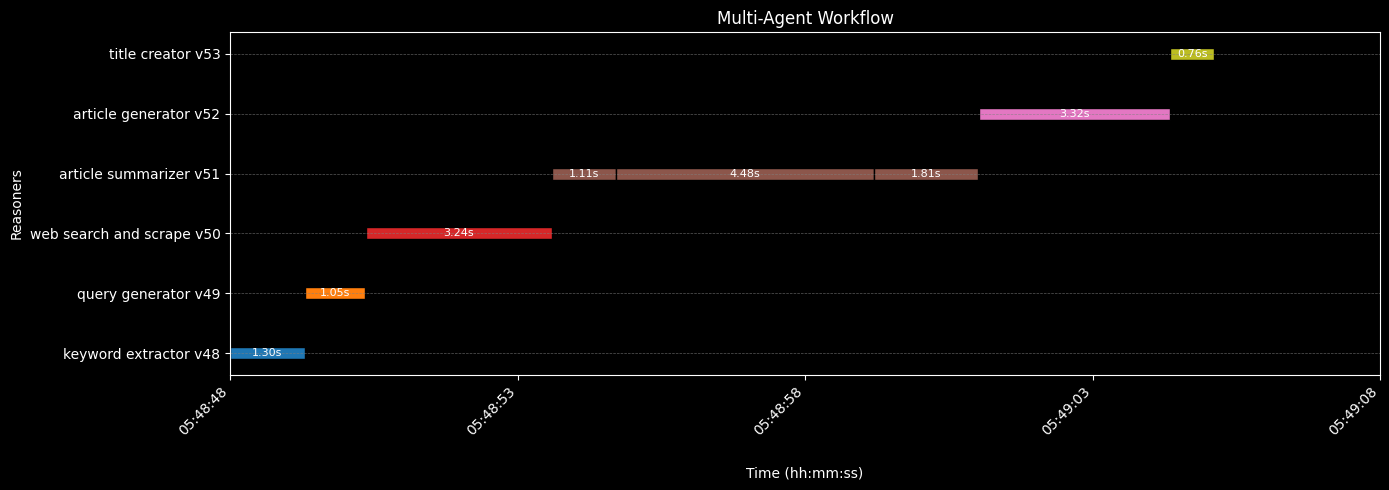

In [18]:
from brain.visualize import plot_workflow_matplotlib

session_id="67042369-2ed1-4e45-a009-a9aa2801a736"
lineage = brain_client.get_call_graph(session_id)
fig=plot_workflow_matplotlib(lineage['lineage'])

In [15]:
tweet="""Part of what I’m *most* looking forward to with 
@cluelessonstage
 hitting the West End is watching Emma & Keelan become MASSIVE STARS! 🤩✨ 

They are SO brilliant!"""
person = "KT Tunstall"
result = generate_news_from_tweet(person=person, tweet=tweet)

In [16]:
from rich import print

print(result.generated_article_title)
print(result.generated_article_content)

KT Tunstall's Twitter Love: Fueling Emma & Keelan's Rise to West End Stardom! 🌟🎭

In a recent tweet, KT Tunstall expressed her excitement about the upcoming arrival of the production 
@cluelessonstage to the West End, particularly focusing on the talents of Emma and Keelan. Tunstall's enthusiastic 
remark, "Part of what I’m *most* looking forward to with @cluelessonstage hitting the West End is watching Emma & 
Keelan become MASSIVE STARS! 🤩✨ They are SO brilliant!" underscores her belief in their extraordinary talent and 
potential. This statement not only reflects Tunstall's authentic support for upcoming artists but also serves to 
amplify the visibility of new talent in the competitive environment of the West End theater scene.

Tunstall's endorsement resonates deeply within the artistic community, highlighting a crucial theme of mentorship 
and support for emerging performers. As someone who has experienced the challenges of stardom herself, she 
understands the significance of recognition and encouragement from established artists in paving the way for 
newcomers. The excitement she expresses captures the attention of audiences and the industry alike, shedding light 
on the fresh, vibrant performances that @cluelessonstage promises to deliver. 

The buzz sparked by Tunstall's tweet reveals a collective anticipation within the theater-going community, as fans 
and critics begin to discuss the potential impact of Emma and Keelan's performances. This discussion reflects a 
broader trend where established artists leverage their platforms to support new talent, fostering a collaborative 
environment that benefits the arts as a whole.

By championing Emma and Keelan, Tunstall not only propels their careers but also ignites conversations about the 
importance of artistic collaboration and the power of social media in shaping the narratives surrounding emerging 
stars. Her tweet stands as a testament to the interconnectedness of the artistic community and the pivotal role of 
encouragement in the growth of new talents on prestigious stages like the West End.